This is the implementation of the multivariate linear model with all the available variables.

The training and validation process is the same as univariate process. Hourly forecasts for a day ahead are implemented for the total one-year training. The training set is then moved ahead by one day and the process is repeated for all available data.


In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from statsmodels.tsa.vector_ar.var_model import VAR,VARResults
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
path = os.path.join(os.path.expanduser('~'), 'Documents', 'for_edit', 'GERMANY_WITH_NAN.xlsx')
print (path)

/home/giorgos/Documents/for_edit/GERMANY_WITH_NAN.xlsx


In [3]:
def evaluate_performance(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100
    return mse,rmse,mae,mape

In the Full model, all the available variables are used for training.

In [4]:
df = pd.read_excel(path)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.set_index('Date Time')
df.index = pd.to_datetime(df.index)
first_column = df.pop('Actual_Load')
df.insert(0, 'Actual_Load', first_column)
df

,Actual_Load,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),holiday
Date Time,,,,,,,,,,,,,,,,
2012-10-01 01:00:00,39296.0,997.12,5.85,279.24,3.91,87.30,9.26,8.08,1.18,5.06,8.11,1241.17,3.33,6.13,258.5,0.0
2012-10-01 02:00:00,39623.0,997.45,6.05,279.41,3.94,86.30,9.39,8.10,1.29,5.07,8.12,1240.67,3.05,6.29,266.0,0.0
2012-10-01 03:00:00,41180.0,998.57,5.38,278.66,3.93,90.30,8.97,8.10,0.87,5.06,8.11,1245.04,2.38,5.81,265.5,0.0
2012-10-01 04:00:00,44793.0,999.37,4.54,277.75,2.40,85.90,8.45,7.26,1.19,4.53,7.27,1250.21,1.91,3.76,278.4,0.0
2012-10-01 05:00:00,53632.0,1000.05,4.43,277.59,1.57,81.60,8.39,6.84,1.54,4.27,6.84,1251.76,1.85,3.68,282.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-02 13:00:00,68624.0,971.30,2.97,278.44,-3.15,63.96,7.56,4.84,2.73,3.10,4.98,1223.08,2.92,5.25,229.5,0.0
2015-02-02 14:00:00,67280.0,971.26,2.81,278.28,-2.98,65.56,7.48,4.90,2.58,3.15,5.05,1223.71,3.65,6.21,241.4,0.0
2015-02-02 15:00:00,66108.0,971.35,2.93,278.40,-2.78,65.91,7.55,4.97,2.57,3.19,5.12,1223.23,1.68,2.80,213.3,0.0


Make sure that the dataset is the correct one, without missing values in the x axis(time)
In timeseries data, missing values on the x axis could have asignificant impact on the quality of the predictions

In [5]:
df = df.sort_index()
df= df.interpolate()
df.loc['2012-10-24 10:00:00']

Actual_Load        64579.000
p (mbar)             995.060
T (degC)               7.420
Tpot (K)             280.975
Tdew (degC)            6.965
rh (%)                96.900
VPmax (mbar)          10.325
VPact (mbar)          10.000
VPdef (mbar)           0.320
sh (g/kg)              6.275
H2OC (mmol/mol)       10.055
rho (g/m**3)        1230.745
wv (m/s)               1.075
max. wv (m/s)          1.490
wd (deg)              98.875
holiday                0.000
Name: 2012-10-24 10:00:00, dtype: float64

For the correct evaluation of the predictions, the application of cross-validation is useful. The size of the training set must be fixed so that we do not favor subsequent checks with a larger training set. For this purpose, we move the training data window by one day.

The training of the model and the predictions procedure is repeated for 494 days so as to use all the available data. This procedure is implemented as a form of cross-validation which is well-established for time series cases where cutting off pieces from the training set is prohibited.


In [6]:
from sklearn.model_selection import TimeSeriesSplit
splits=494
horizon=24
tss = TimeSeriesSplit(n_splits=splits,max_train_size=24*30*12, test_size=horizon)
df = df.sort_index()

In [7]:
fold = 0
preds = []
mse=[]
rmse=[]
mae=[]
mape=[]

WINDOW_SIZE = 25
number_of_fold = 1
hourly_errors = np.zeros(shape=(splits,horizon))
fold_counter=0
full_real = np.zeros(shape=(splits,horizon))
for train_idx, val_idx in tss.split(df):
    if number_of_fold<splits:
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]


        sc = MinMaxScaler()
        train = sc.fit_transform(train)
        test= sc.fit_transform(test)

        model = VAR(endog=train)
        model_fit = model.fit(26)
        lagged_Values=train[-26:]
        y_pred = model_fit.forecast(y=lagged_Values, steps=horizon)

        predictions = sc.inverse_transform(y_pred)
        dataY_real=sc.inverse_transform(test)
        mse1,rmse1,mae1,mape1 = evaluate_performance(predictions[:,0], dataY_real[:,0])
        for i in range(horizon):
            hourly_errors[fold_counter,i]=predictions[i,0]-dataY_real[i,0]
            full_real[fold_counter,i] = dataY_real[i,0] 


        mse.append(mse1)
        rmse.append(rmse1)
        mae.append(mae1)
        mape.append(mape1)
        number_of_fold=number_of_fold+1
        fold_counter=fold_counter+1


scores=pd.DataFrame(list(zip(mse, rmse,mae,mape)),columns=['mse','rmse','mae','mape'])
#scores

Aftewards we need to create the dataframes so as to store the results properly. The hourly evaluations will measure how well the model predicts for each hour ahead.

In [8]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
hourly_evaluations= pd.DataFrame(hourly_errors,columns=cols)
aa= pd.DataFrame(full_real,columns=cols)#This dataframe just holds the actual values

In [9]:
mse=[]
rmse=[]
mae=[]
mape=[]
her = np.zeros(shape=(splits,4))
for i in range(horizon):
    temp = hourly_errors[0:splits-1,i]
    mse1 = np.square(temp).mean()
    rmse1 = np.sqrt(mse1)
    mae1 = np.abs(temp).mean()
    mape1 = np.mean(np.abs(temp/full_real[0:splits-1,i]))*100
    mse.append(mse1)
    rmse.append(rmse1)
    mae.append(mae1)
    mape.append(mape1)
    
hourly_scores=pd.DataFrame(list(zip(mse, rmse,mae,mape)),columns=['mse','rmse','mae','mape'])
hourly_scores

,mse,rmse,mae,mape
0,1.596043e+07,3995.050509,3340.503549,5.939285
1,1.038884e+07,3223.171932,2606.304534,4.797465
2,6.487300e+06,2547.017945,1999.774492,3.858303
3,7.890970e+06,2809.087095,2368.045126,4.606127
4,1.258473e+07,3547.495949,3052.367089,6.184069
5,2.335995e+07,4833.213702,4205.700109,8.935012
6,3.395357e+07,5826.969403,5247.507142,11.657934
7,4.181594e+07,6466.524508,5970.078926,13.681317
8,4.528738e+07,6729.589616,6264.061017,14.498746
9,4.382311e+07,6619.902692,6167.380804,14.198710


Finally we print out some plots

The hourly errors will allows us to examine how good the predictions are for each hour ahead. From the chart below, we can see that the model fails to produce accurate predictions. 

Text(0, 0.5, 'MAPE')

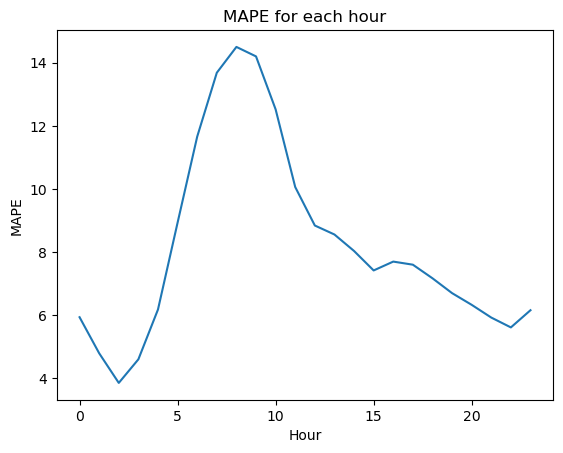

In [10]:
ax = hourly_scores['mape'].plot(title='MAPE for each hour')
ax.set_xlabel("Hour")
ax.set_ylabel("MAPE")

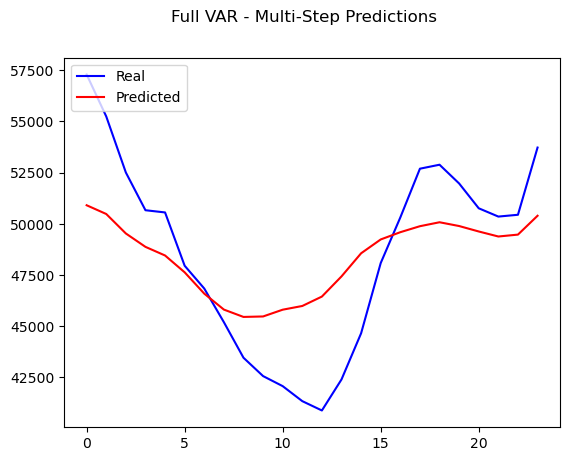

In [11]:
plt.clf()
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(dataY_real[:,0],'b', label="Real")
plt.plot(predictions[:,0],'r', label="Predicted")
plt.legend(loc="upper left")
plt.suptitle('Full VAR - Multi-Step Predictions')
plt.show()

In [12]:
scores2 = scores["mape"].mean()
print(scores2)

8.2088439595016


Save the results to new files

In [13]:
# scores.to_excel('FULL_VAR_SCORES_GER.xlsx', sheet_name='VAR_SCORES_GER')
# hourly_scores.to_excel('FULL_VAR_HOURLY_SCORES_GER.xlsx', sheet_name='FULL_VAR_HOURLY_SCORES_GER')
# hourly_evaluations.to_excel('FULL_VAR_HOURLY_ERRORS_GER.xlsx', sheet_name='FULL_VAR_HOURLY_ERRORS_GER')
# aa.to_excel('FULL_VAR_HOURLY_REAL_GER.xlsx', sheet_name='FULL_VAR_HOURLY_REAL_GER')